In [1]:
! pip install imblearn

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #for balanced

# For reproducibility of results
np.random.seed(0)

# Load the dataset
file_path = 'rtfDataSet.csv'
original_data = pd.read_csv(file_path)

# Display first few rows of the original dataset
original_data.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,label
0,-0.536,0.292,-0.684,0.123,-0.118,0.346,-0.308,-0.113,0.401,-0.399,...,-0.135,-0.063,-0.410,-0.223,-0.599,-0.136,-0.329,-0.132,-0.266,0
1,-0.496,-0.298,-0.529,0.073,-0.072,0.107,-0.316,-0.066,-0.168,-0.099,...,0.189,0.007,-0.362,-0.151,-0.338,-0.031,-0.159,-0.097,-0.131,0
2,0.008,-0.031,-0.240,0.178,-0.120,0.317,-0.481,0.031,-0.077,0.063,...,-0.035,0.101,-0.098,-0.172,-0.290,0.033,-0.342,-0.321,-0.238,0
3,-0.188,-0.180,-0.062,-0.104,-0.136,-0.061,-0.216,-0.143,0.068,-0.189,...,0.146,-0.145,-0.527,-0.292,-0.663,-0.078,-0.194,-0.151,-0.268,0
4,0.038,0.155,-0.203,-0.088,-0.084,-0.164,-0.145,-0.168,0.008,0.143,...,0.019,-0.084,0.164,-0.165,-0.126,-0.112,0.029,-0.138,0.148,1


In [3]:
# Normalizing the data using Min-Max scaling
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(original_data.iloc[:,:-1]), columns=original_data.columns[:-1]) # Normalize all data except for the last column (label)
normalized_data['label'] = original_data['label']

save_csv = 'normalized_dataset.csv'
normalized_data.to_csv(save_csv, index=False)

# # argmax and argmin of normalized_data
# normalized_data.idxmax(), normalized_data.idxmin()
# normalized_data['label'][198]

normalized_data.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,label
0,0.294244,0.705043,0.183047,0.610883,0.287570,0.806475,0.179009,0.499009,0.890763,0.184259,...,0.378264,0.459459,0.300824,0.339323,0.180758,0.348815,0.324151,0.526825,0.128294,0
1,0.315761,0.143673,0.263651,0.559548,0.330241,0.630611,0.174344,0.522299,0.433735,0.462037,...,0.606916,0.529530,0.333791,0.389081,0.332945,0.448341,0.433056,0.543741,0.221914,0
2,0.586875,0.397716,0.413937,0.667351,0.285714,0.785136,0.078134,0.570367,0.506827,0.612037,...,0.448836,0.623624,0.515110,0.374568,0.360933,0.509005,0.315823,0.435476,0.147712,0
3,0.481442,0.255947,0.506500,0.377823,0.270872,0.506990,0.232653,0.484143,0.623293,0.378704,...,0.576570,0.377377,0.220467,0.291638,0.143440,0.403791,0.410634,0.517641,0.126907,0
4,0.603012,0.574691,0.433177,0.394251,0.319109,0.431199,0.274052,0.471754,0.575100,0.686111,...,0.486944,0.438438,0.695055,0.379406,0.456560,0.371564,0.553491,0.523925,0.415395,1


In [4]:
# Load the normalized dataset (This can be adjusted to the working dataset in case there is some matching problems)
file_path = 'normalized_dataset.csv'
data = pd.read_csv(file_path)

In [5]:
# Separate the features (X) and labels (y)
x = data.drop(columns=['label'])
y = data['label']

# Apply SMOTE to balance the dataset // Great job using a seed
smote = SMOTE(random_state=42) 
x_balanced, y_balanced = smote.fit_resample(x, y)

# Standardize the features
scaler = StandardScaler()
x_balanced = scaler.fit_transform(x_balanced)

In [9]:
# Define the number of iterations for Simulated Annealing
n_iterations = 2000

# Initialize the best solution and its score
best_solution = None
best_score = 0

# Initialize the current solution and its score
current_solution = pd.DataFrame(x_balanced, columns=x.columns)  # Use the balanced dataset
current_score = 0

# Define an initial temperature and cooling rate
T_initial = 4.0  # Initial temperature
alpha = 0.95  # Cooling rate

# Define a small constant to avoid division by zero in the SU function
epsilon = 1e-10

# Symmetrical Uncertainty function
def symmetrical_uncertainty(x, y, epsilon):
    mi = mutual_info_classif(x, y)
    h_x = -np.sum(np.log2((x.sum() + epsilon) / (x.sum().sum() + epsilon)))
    su = 2 * np.sum(mi) / h_x
    return su

In [10]:

#
# Initialize a list to store the importance scores for each subset
subset_importance_scores = []

# Feature selection pipeline
def feature_selection_pipeline(data, target, n_subsets=10, correlation_threshold=0.7):
    # Step 1: Calculate the Pearson correlation matrix
    correlation_matrix = data.corr()

    # Step 2: Create the first subset based on Pearson correlation
    subset_1 = []
    remaining_features = data.columns.tolist()

    while len(remaining_features) > 0:
        current_feature = remaining_features[0]
        subset_1.append(current_feature)

        # Find correlated features and remove them
        correlated_features = [current_feature]
        for feature in remaining_features[1:]:
            if abs(correlation_matrix[current_feature][feature]) > correlation_threshold:
                correlated_features.append(feature)

        remaining_features = [feature for feature in remaining_features if feature not in correlated_features]

    subsets = [subset_1]
     # Step 3 and 4: Calculate SU scores and create the remaining subsets
    for i in range(2, n_subsets + 1):
        # Calculate SU scores for the remaining features
        su_scores = []
        for feature in remaining_features:
            su = symmetrical_uncertainty(data[subset_1], data[feature], epsilon)
            su_scores.append((feature, su))

        # Sort features by SU score in descending order
        if su_scores:
            # Keep a few features with high SU scores and remove redundant ones
            subset_i = [su_scores[0][0]]
            remaining_features = [feature for feature, _ in su_scores[1:]]
            subsets.append(subset_i)
        else:
            # If there are no more features with high SU scores, exit the loop
            break

    return subsets

# Generate 10 feature subsets using the feature selection pipeline
subsets = feature_selection_pipeline(pd.DataFrame(x_balanced, columns=x.columns), y_balanced, n_subsets=10, correlation_threshold=0.7)



# Simulated Annealing loop (this code could be improved)
for iteration in range(n_iterations):
    # Make a small random change to the current solution (feature selection)
    feature_to_change = np.random.choice(current_solution.columns)
    current_solution[feature_to_change] = np.random.choice([0, 1])
    
    # Calculate the Symmetrical Uncertainty score for the current solution
    current_score = symmetrical_uncertainty(current_solution, y_balanced, epsilon=epsilon)
    
    # Calculate the change in score
    delta_score = current_score - best_score
    
    # Accept the new solution with a certain probability based on the temperature
    if delta_score > 0 or np.random.uniform() < np.exp(delta_score / T_initial):
        best_solution = current_solution.copy()
        best_score = current_score
    
    # Update the temperature using the cooling rate
    T_initial *= alpha
    
    # Calculate the importance of the selected features in the current solution
    selected_features = current_solution.columns[current_solution.sum() > 0]
    importance_per_capita = current_score / len(selected_features)
    subset_importance_scores.append(importance_per_capita)

Selected Features:
Index(['1', '2', '3', '5', '6', '9', '10', '11', '15', '16', '18', '19', '21',
       '22', '23', '24', '25', '27', '28', '31', '32', '33', '34', '37', '38',
       '39', '40', '41', '42', '43', '45', '46', '47', '50', '52', '53', '55',
       '56', '57', '59', '60', '61', '66', '67', '68', '69'],
      dtype='object')
Symmetrical Uncertainty Score: 0.0014315341154488642
Importance Per Capita: 3.1120306857584e-05


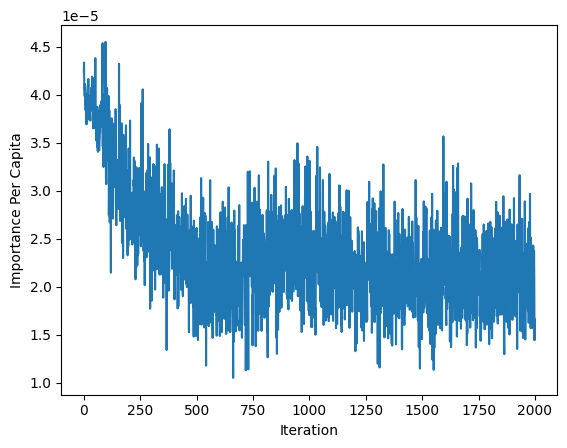


Generated Feature Subsets:
Subset 1: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '17', '18', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '51', '52', '53', '55', '56', '57', '58', '60', '61', '62', '64', '66', '67', '68', '69']


In [11]:
# Print the selected features and their Symmetrical Uncertainty score
selected_features = best_solution.columns[best_solution.sum() > 0]
print("Selected Features:")
print(selected_features)
print("Symmetrical Uncertainty Score:", best_score)

# Calculate the importance per capita for the best solution
best_importance_per_capita = best_score / len(selected_features)
print("Importance Per Capita:", best_importance_per_capita)

# Plot the importance scores over iterations (optional)
import matplotlib.pyplot as plt
plt.plot(range(n_iterations), subset_importance_scores)
plt.xlabel("Iteration")
plt.ylabel("Importance Per Capita")
plt.show()

# Print the generated subsets
print("\nGenerated Feature Subsets:")
for i, subset in enumerate(subsets):
    print(f"Subset {i + 1}: {subset}")

In [12]:
# TODO: 3. Top Five Feature Subsets

# Use the feature selection method to identify the top five feature subsets
# Calculate the per capita importance for each subset

# Initialize a list to store the top five feature subsets and their importance scores
top_five_subsets = []
for iteration in range(n_iterations):
    # Make a small random change to the current solution (feature selection)
    feature_to_change = np.random.choice(current_solution.columns)
    current_solution[feature_to_change] = np.random.choice([0, 1])
    
    # Calculate the Symmetrical Uncertainty score for the current solution
    current_score = symmetrical_uncertainty(current_solution, y_balanced, epsilon=epsilon)
    
    # Calculate the change in score
    delta_score = current_score - best_score
    
    # Accept the new solution with a certain probability based on the temperature
    if delta_score > 0 or np.random.uniform() < np.exp(delta_score / T_initial):
        best_solution = current_solution.copy()
        best_score = current_score
    
    # Update the temperature using the cooling rate
    T_initial *= alpha
    
    # Calculate the importance of the selected features in the current solution
    selected_features = current_solution.columns[current_solution.sum() > 0]
    importance_per_capita = current_score / len(selected_features)
    subset_importance_scores.append(importance_per_capita)

    if len(top_five_subsets) < 5:
        top_five_subsets.append((current_solution.columns[current_solution.sum() > 0], current_score))
        top_five_subsets.sort(key=lambda x: x[1], reverse=True)
    else:
        if current_score > top_five_subsets[-1][1]:
            top_five_subsets[-1] = (current_solution.columns[current_solution.sum() > 0], current_score)
            top_five_subsets.sort(key=lambda x: x[1], reverse=True)
# Print the top five feature subsets and their Symmetrical Uncertainty scores
print("Top Five Feature Subsets:")
for i, (subset_features, subset_score) in enumerate(top_five_subsets):
    print(f"Subset {i+1}: {subset_features}")
    print(f"Symmetrical Uncertainty Score: {subset_score}")

# Calculate the importance per capita for the top five subsets
print("\nImportance Per Capita for Top Five Subsets:")
for i, (subset_features, subset_score) in enumerate(top_five_subsets):
    importance_per_capita = subset_score / len(subset_features)
    print(f"Subset {i+1} - Importance Per Capita: {importance_per_capita}")


Top Five Feature Subsets:
Subset 1: Index(['0', '4', '9', '10', '14', '17', '18', '19', '22', '23', '24', '25',
       '26', '28', '29', '31', '32', '33', '34', '35', '36', '37', '39', '41',
       '42', '43', '44', '45', '46', '48', '49', '52', '53', '55', '57', '62',
       '66', '67', '68', '69'],
      dtype='object')
Symmetrical Uncertainty Score: 0.001336024279928695
Subset 2: Index(['0', '1', '2', '3', '4', '6', '7', '8', '9', '10', '12', '13', '14',
       '18', '20', '21', '22', '23', '25', '26', '29', '32', '35', '36', '39',
       '40', '41', '45', '50', '54', '56', '60', '62', '63', '65', '67'],
      dtype='object')
Symmetrical Uncertainty Score: 0.0011965120482418374
Subset 3: Index(['0', '3', '4', '5', '8', '12', '13', '14', '15', '16', '17', '19', '21',
       '22', '24', '25', '26', '28', '29', '33', '34', '36', '39', '40', '42',
       '45', '47', '48', '49', '50', '52', '53', '55', '57', '59', '62', '63',
       '64', '65', '67', '69'],
      dtype='object')
Symmetri

In [ ]:

# TODO: 4. AUC Score-based Ranking

# Use a classification model (e.g., logistic regression, SVM, etc.) to evaluate the feature subsets
# Rank the top five feature subsets based on their AUC scores

In [ ]:

# TODO: 5. Interpretation and Conclusion

# Interpret the per capita importance and the AUC scores
# Conclude the study, noting any limitations and suggesting future work